###  Example of the spectral PLV computation

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                       import tqdm
from   xfrites.conn.conn_spec_plv import conn_spec_plv

#### Defining function to simulate de model

In [2]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in tqdm( range(Trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

Model parameters

In [3]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 100   # Number of trials
freqs  = np.arange(1,100,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

Generating data

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


In [5]:
X = xr.DataArray(X, dims=('trials', 'roi', 'times'),
                 coords=(np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

### Measuring spectral phase-locking value

In [15]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=None, roi=None, foi=None, n_jobs=20,
    sfreq=Fs, mode='morlet', n_cycles=n_cycles, decim=10,
    block_size=1, kw_win=dict(slwin_len=1,slwin_step=0.1)
)

# compute the coherence
plv = conn_spec_plv(X.values, **kw).astype(np.float32)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 3.852330446243286 sec.


Text(0.5, 1.0, 'Spectral PLV')

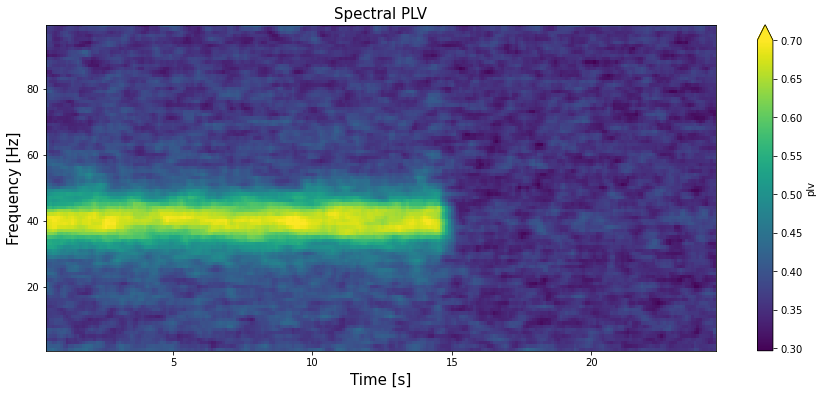

In [19]:
plt.figure(figsize=(15,6))
plv.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmax=.7)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Spectral PLV', fontsize=15)

### Single-trial spectral PLV

Here we average over bands of interest and plot the PLV at single-trial level.

In [20]:
# Define frequencies of interest (foi)
foi = np.array(
                [[0,25],
                [25,50],
                [50,75],
                [75,100]]
              )

kw = dict(
    freqs=freqs, times=None, roi=None, foi=foi, n_jobs=20,
    sfreq=Fs, mode='morlet', n_cycles=n_cycles, decim=10,
    block_size=1, kw_win=dict(slwin_len=1,slwin_step=0.1)
)

In [21]:
plv = conn_spec_plv(X.values, **kw).astype(np.float32)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

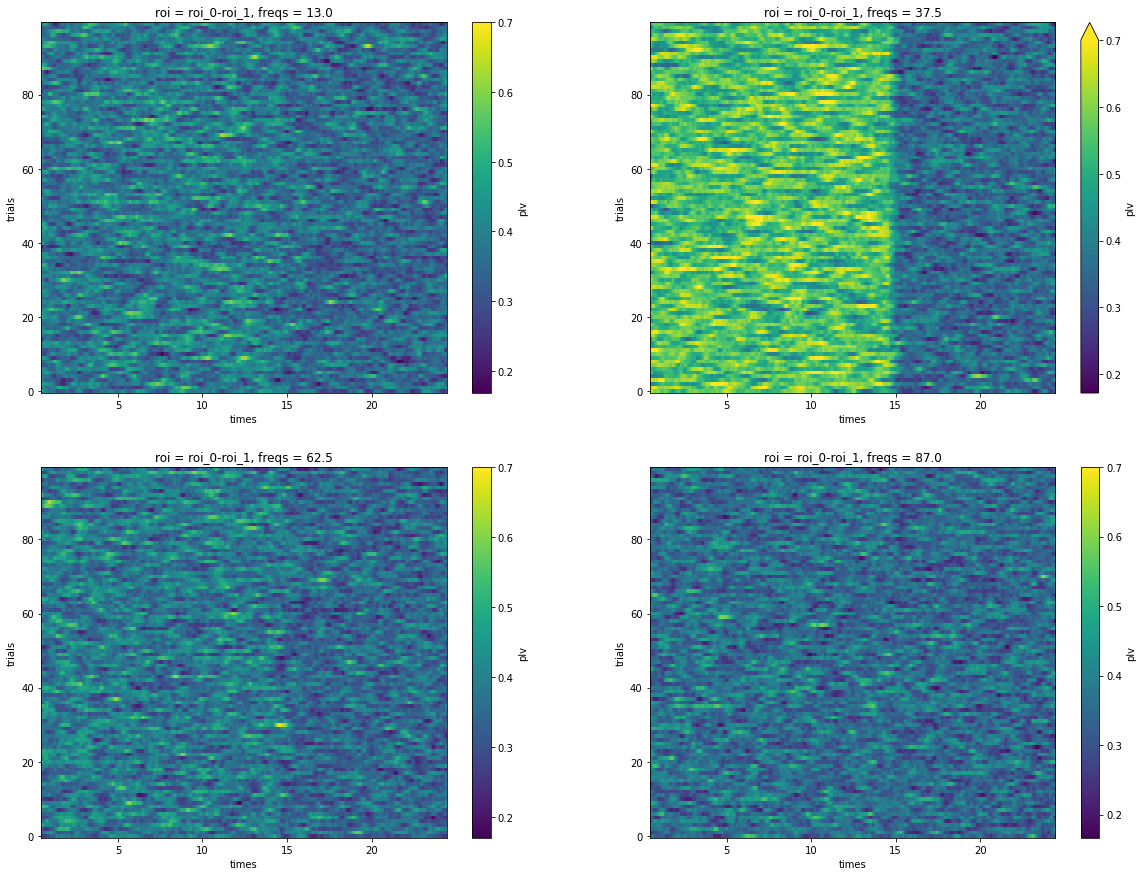

In [24]:
plt.figure(figsize=(20,15))
for i in range(plv.sizes['freqs']):
    plt.subplot(2,2,i+1)
    plv.isel(roi=0, freqs=i).plot.imshow(x="times", y="trials", vmax=.7)
    #plt.title(bands[i])

### Surrogates

In [25]:
from GDa.signal.surrogates import phase_rand_surrogates

In [40]:
# Compute PLV for original data
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=None, roi=None, foi=None, n_jobs=20,
    sfreq=Fs, mode='morlet', n_cycles=n_cycles, decim=10,
    block_size=1, kw_win=dict(slwin_len=1,slwin_step=0.1)
)

# compute the coherence
plv = conn_spec_plv(X.values, **kw).astype(np.float32)

end = time.time()

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [32]:
def _surrogate_coh(n_surr,val):
    
    # define temporal windows + compute the DFC
    n_cycles = freqs / 2.

    seeds = np.arange(n_surr, dtype=int) * 100

    kw = dict(
        freqs=freqs, times=None, roi=None, foi=None, n_jobs=20,
        sfreq=Fs, mode='morlet', n_cycles=n_cycles, decim=10,
        block_size=1, kw_win=dict(slwin_len=1,slwin_step=0.1)
    )
    
    plv = []
    for seed in tqdm( seeds ):
        X_rnd = phase_rand_surrogates(X,val=val,seed=seed,verbose=False)
        plv  += [conn_spec_plv(X_rnd.values, **kw).astype(np.float32)]
    return xr.concat(plv, "seeds")

In [33]:
plv_surr = _surrogate_coh(10,1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.18s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:08<00:33,  4.17s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 30%|███       | 3/10 [00:12<00:28,  4.12s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 40%|████      | 4/10 [00:16<00:24,  4.09s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [00:20<00:20,  4.07s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [00:24<00:16,  4.06s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [00:28<00:12,  4.06s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [00:32<00:08,  4.07s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [00:36<00:04,  4.02s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.95, step=0.1)
    240 windows defined
Compute spectral phase-locking value (n_pairs=1, n_freqs=99, decim=10)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


Text(0.5, 1.0, 'Spectral PLV Surrogate')

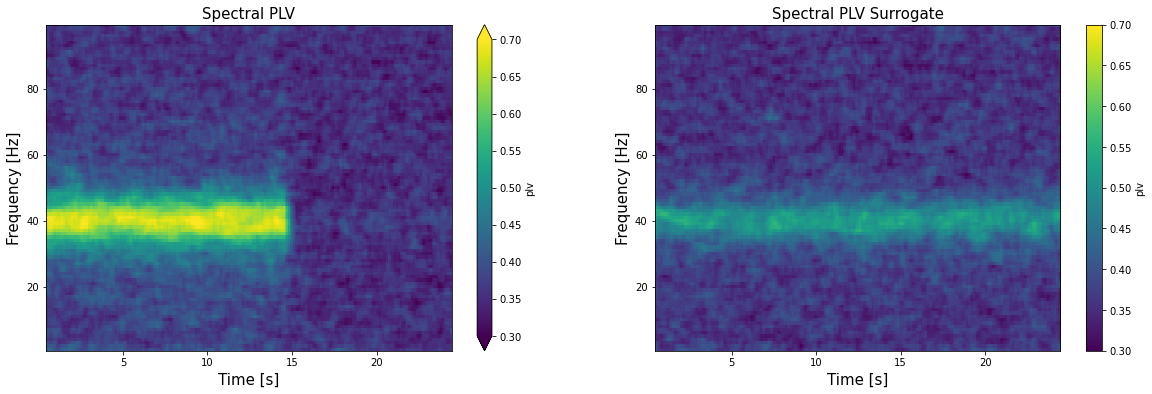

In [44]:
plt.figure(figsize=(20,6))
# Original 
plt.subplot(1,2,1)
plv.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmin=0.3, vmax=0.7)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Spectral PLV', fontsize=15)
# Surrogate
plt.subplot(1,2,2)
plv_surr.isel(roi=0, seeds=8).mean(dim="trials").plot.imshow(x="times", y="freqs", vmin=0.3,  vmax=0.7)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Spectral PLV Surrogate', fontsize=15)

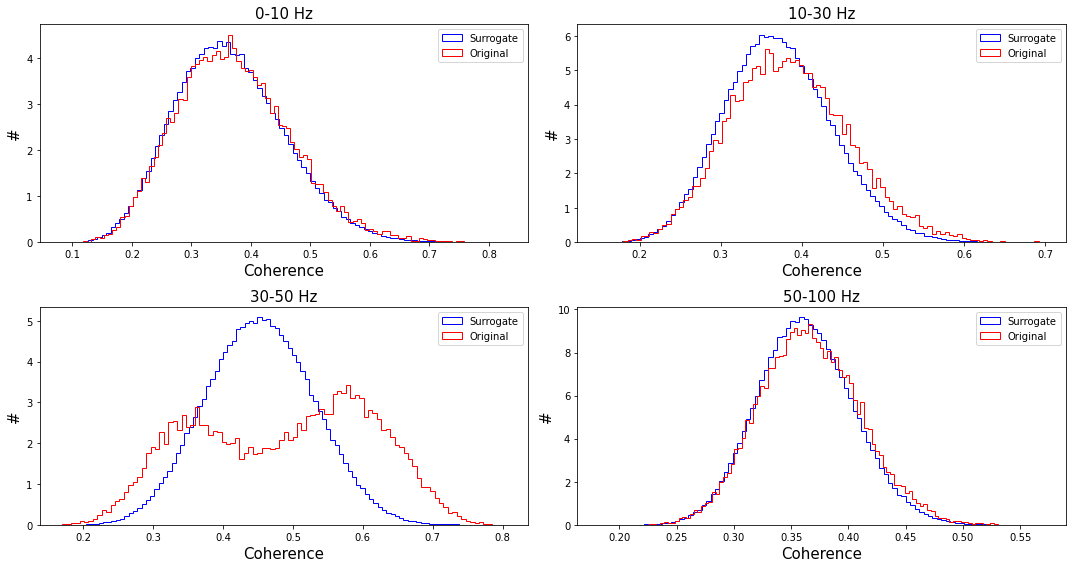

In [47]:
foi = [[0,10],[10,30],[30,50],[50,100]]
plt.figure(figsize=(15,8))
count=1
for i,f_c in enumerate(foi):
    plt.subplot(2,2,i+1)
    plt.hist(plv_surr.sel(freqs=slice(f_c[0],f_c[1])).mean(dim='freqs').values.flatten(), density=True,bins=100, label='Surrogate', histtype='step', fill=False, color='b');
    plt.hist(plv.sel(freqs=slice(f_c[0],f_c[1])).mean(dim='freqs').values.flatten(), density=True,bins=100, label='Original', histtype='step', fill=False, color='r');
    plt.ylabel('#', fontsize=15)
    plt.xlabel('Coherence', fontsize=15)
    plt.legend()
    plt.title(f'{f_c[0]}-{f_c[1]} Hz', fontsize=15)
    count += 1
plt.tight_layout()